In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle

import sys
import os
project_path = os.path.expanduser('~/repos/metric_graph/')
sys.path.append(project_path)

from construct_graph.graph import Graph, Flat
import solve_laplace_operator
from calculations.helper_functions import sequential_Newton, check_convergence, style_plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
file = open("../data/delaunay/drum_eigenvalues/drum_eigenvalues.pkl", "rb")
eigenvalues = pickle.load(file)
file.close()

In [23]:
class Random_Delaunay_Disc(Graph, Flat):

    def __init__(self, num_Vs, plot_graph=False):

        self.num_Vs = num_Vs
        self.V_coords, self.edges, self.interior_V_num = self.construct_graph_data()

        self.E_lengths_by_v_num, self.wadjacency_matrix = self.construct_length_data()

        self.edges = self.construct_edges()

        self.g_coords = self.construct_g_coords()

        if plot_graph:
            self.plot()

    def construct_edges(self):

        edges = []
        for (v, w), l_vw in self.E_lengths_by_v_num.items():
            edge = {"vw": (v, w),
                    "l_vw": l_vw,
                    "vw_coords": np.array((self.V_coords[v], self.V_coords[w]))}
            edges.append(edge)

        return edges

    def construct_graph_data(self):

        r = list(np.sqrt(np.random.uniform(0, 2, size=1)))
        disc_count = int(r[0] < 1)
        while disc_count < self.num_Vs:
            next_r = np.sqrt(np.random.uniform(0, 2))
            r.append(next_r)
            disc_count += int(next_r < 1)
        r = np.sort(r)
        theta = np.random.uniform(0, 2 * np.pi, len(r))
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        V_coords = np.vstack((x, y)).T

        triangulation = scipy.spatial.Delaunay(V_coords)
        V_coords = V_coords[:self.num_Vs]
        
        V, W = triangulation.vertex_neighbor_vertices

        edges = []
        boundary_V_num = []

        for v in range(self.num_Vs):
            w_inds = W[V[v]:V[v + 1]]
            for w in w_inds:
                if v < w:
                    if w > self.num_Vs - 1:
                        boundary_V_num.append(v)
                    else:
                        edges.append([v, w])
        
        edges = np.array(edges)
        boundary_V_num = np.unique(boundary_V_num)
        V_coords[boundary_V_num] /= np.linalg.norm(V_coords[boundary_V_num], axis=1, keepdims=True)

        interior_V_num = np.setdiff1d(np.arange(self.num_Vs), boundary_V_num)

        return V_coords, edges, interior_V_num
    
    def construct_length_data(self):

        wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
        E_lengths_by_v_num = {}

        for v, w in self.edges:
            l_vw = np.linalg.norm(self.V_coords[v] - self.V_coords[w])
            wadjacency_matrix[v, w] = l_vw
            wadjacency_matrix[w, v] = l_vw
            E_lengths_by_v_num[v, w] = l_vw

        wadjacency_matrix = wadjacency_matrix.tocsc()

        return E_lengths_by_v_num, wadjacency_matrix
    
    def plot(self):

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

        ax.scatter(self.V_coords[:, 0], self.V_coords[:, 1], s=5)

        # for coords in self.V_coords:
        #     if np.linalg.norm(coords) < 1:
        #         ax.scatter(coords[0], coords[1], s=10, c='b')
        #     else:
        #         ax.scatter(coords[0], coords[1], s=10, c='r')
        ax.set_aspect('equal')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)

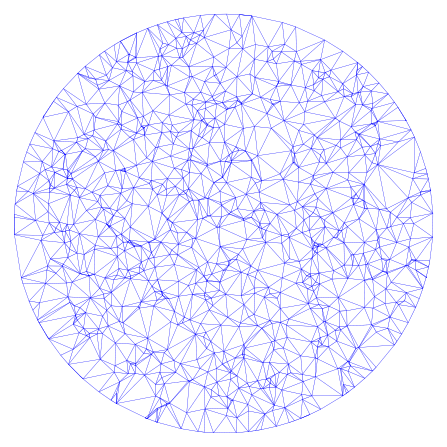

In [24]:
num_Vs = 1000
seed = 0
np.random.seed(seed)
g = Random_Delaunay_Disc(num_Vs, plot_graph=False)
fig, ax = g.plot_graph(return_figax=True, figsize=5, linewidth=0.2)#, capstyle=None)

In [26]:
num_Vs = 1000
seed = 0

np.random.seed(seed)
g = Random_Delaunay_Disc(num_Vs, plot_graph=False)

continuum_eigendata = solve_laplace_operator.solve_laplace_operator.Continuum_Eigendata("disc")
proj = solve_laplace_operator.solve_laplace_operator.Projector(g, eigenvalues[num_Vs][seed], continuum_eigendata)

proj(0, 1)
to_do = {num_Vs: proj.data.copy()}
data = solve_laplace_operator.solve_laplace_operator.Eigendata(to_do)

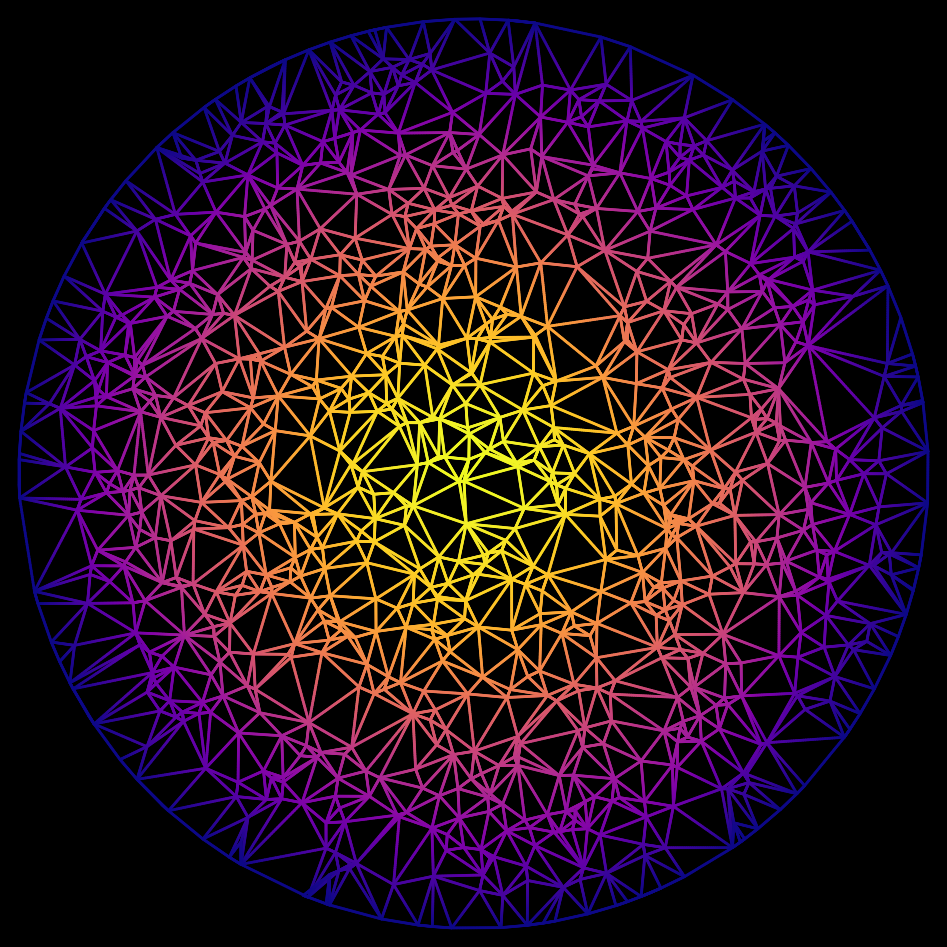

In [62]:
fig, ax = g.plot_graph(return_figax=True,
                       eigenmode=proj.data[0, 1]['graph']['eigenfunction'][0].data, 
                       linewidth=2, background_color="black")

# plt.savefig("../figures/delaunay/disc_graph_mn01.pdf", dpi=300, bbox_inches="tight")

plt.show()

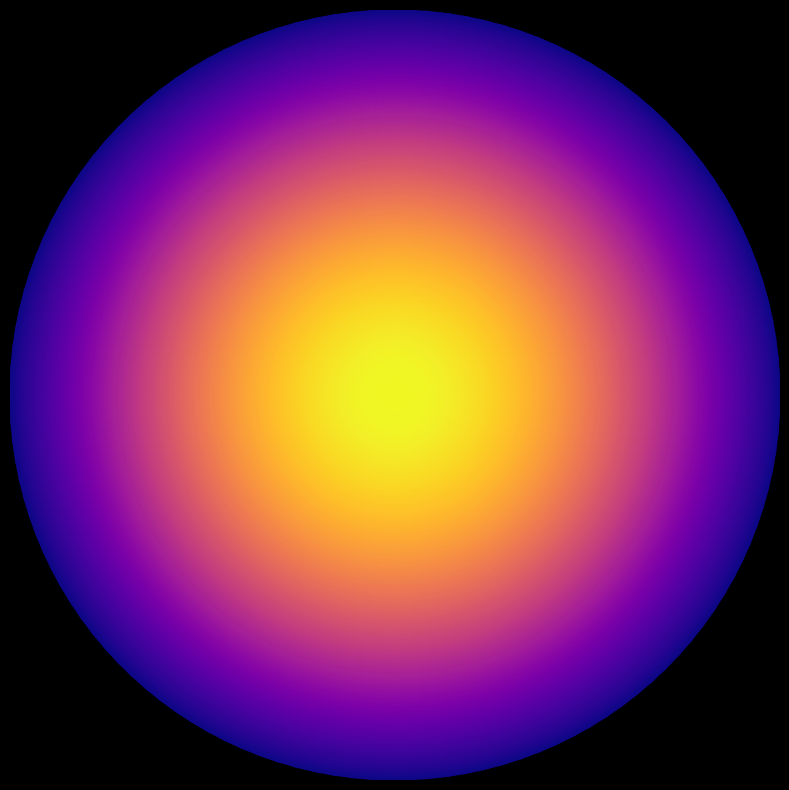

In [67]:
x, y, eigenfunctions = proj.construct_pde_functions(0, 1, "continuum")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Use pcolormesh with correct shading
ax.pcolormesh(x, y, eigenfunctions[0], cmap='plasma', shading='gouraud')

# Custom appearance
ax.axis('off')
fig.set_facecolor("black")
ax.set_facecolor("black")
ax.set_aspect('equal')

plt.savefig("../figures/delaunay/disc_pde_mn01.pdf", dpi=300, bbox_inches="tight")

plt.show()


In [16]:
g = Random_Delaunay_Disc(40000, plot_graph=False)
fig, ax = g.plot_graph(return_figax=True, linewidth=0.2, figsize=10)#, capstyle=None)

plt.savefig("../figures/delaunay/disc_large_graph.png", dpi=300, bbox_inches="tight")

plt.close()

In [3]:
nums_Vs = (10**np.linspace(3, 6, 16)).astype(int)

### Eigenvalues: by calculation or by loading previous eigenvalues

#### By calculation

In [202]:
eigenvalues = {}

In [308]:
for en, num_Vs in enumerate(nums_Vs):

    print(f"\n\ngraph size = {en} / {len(nums_Vs) - 1}\n\n\n")

    eigenvalues[num_Vs] = {}
    check = False
    seed = -1

    guesses = np.linspace(1.5, 2, 1)

    if en == 0:
        previous_mean = None
    else:
        previous_mean = np.mean(means)

    means = []

    while not check:
        seed += 1
        np.random.seed(seed)
        g = Random_Delaunay_Disc(num_Vs)
        print(f"\nSEED = {seed}, num_Vs = {g.num_Vs}\n")
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        full_solutions = sequential_Newton(guesses, eigs)

        eigenvalues[num_Vs][seed] = full_solutions.copy()

        mean = np.mean(list(eigenvalues[num_Vs].values()))
        means.append(mean)

        check = check_convergence(means, mean_previous_graph_size=previous_mean)



graph size = 11 / 15




SEED = 0, num_Vs = 158489


Calculating eig number 0

----------------------
Converged at step 2:

k = 1.6313442195999506
----------------------

SEED = 1, num_Vs = 158489


Calculating eig number 0

----------------------
Converged at step 2:

k = 1.631906245482469
----------------------

SEED = 2, num_Vs = 158489


Calculating eig number 0

----------------------
Converged at step 2:

k = 1.6303681476727057
----------------------

Current dif = 5.690559329595451e-05 vs. adaptive tol = 2.9218765584029426e-07


SEED = 3, num_Vs = 158489


Calculating eig number 0

----------------------
Converged at step 2:

k = 1.6357425566399266
----------------------

Current dif = 0.00014533707273575134 vs. adaptive tol = 1.7456008488963971e-06


SEED = 4, num_Vs = 158489


Calculating eig number 0

----------------------
Converged at step 2:

k = 1.6331553010953477
----------------------

Current dif = 0.00010716981857264592 vs. adaptive tol = 2.817486110349133e-06


SEE

#### Load eigenvalues

In [4]:
file = open("../data/delaunay/drum_eigenvalues/drum_eigenvalues.pkl", "rb")
eigenvalues = pickle.load(file)
file.close()

### Plot results

In [5]:
means = []
drum_nums_Vs = np.array(list(eigenvalues.keys()))
for num_Vs in drum_nums_Vs:
    means.append(np.mean(list(eigenvalues[num_Vs].values())))
means = np.array(means)

In [6]:
coefficient = 0.9201
continuum_eigenvalue = coefficient * scipy.special.jn_zeros(0, 1)**2 / 2

(800, 400000)

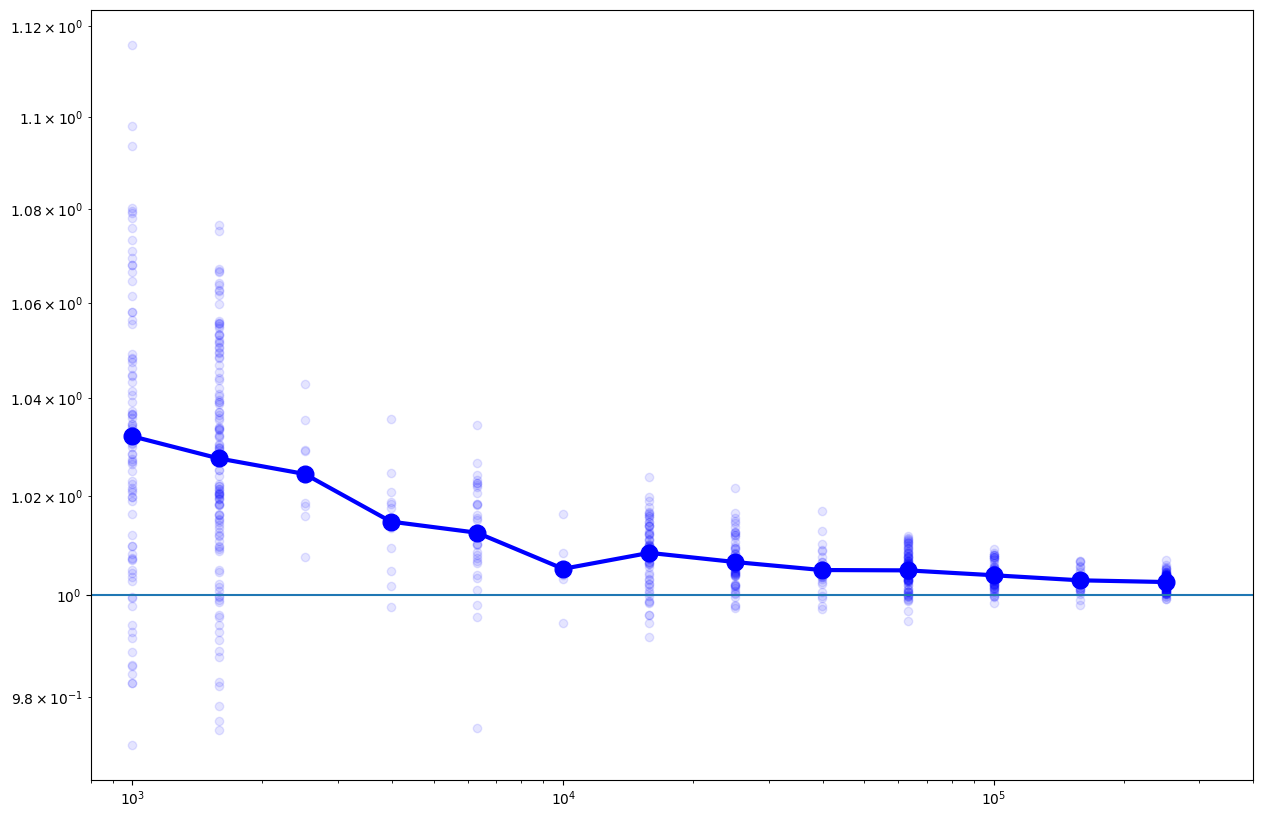

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

eigenvalue_linewidth = 3
eigenvalue_markersize = 12

ax.loglog(drum_nums_Vs, means**2 / continuum_eigenvalue, 'o-', c='b', linewidth=eigenvalue_linewidth, markersize=eigenvalue_markersize)

for num_Vs in eigenvalues:
    data = np.array(list(eigenvalues[num_Vs].values()))**2
    ax.scatter(np.ones(len(data)) * num_Vs, data / continuum_eigenvalue, c='b', zorder=0, alpha=0.1)

ax.hlines(1, 500, 1_000_000)
ax.set_xlim(800, 400_000)

In [40]:
# Vs_difs = np.array([np.abs(drum_nums_Vs[i] - drum_nums_Vs[i + 1]) for i in range(len(drum_nums_Vs) - 1)])
eigs_difs = np.array([np.abs(means[i]**2 - continuum_eigenvalue) for i in range(len(means))])

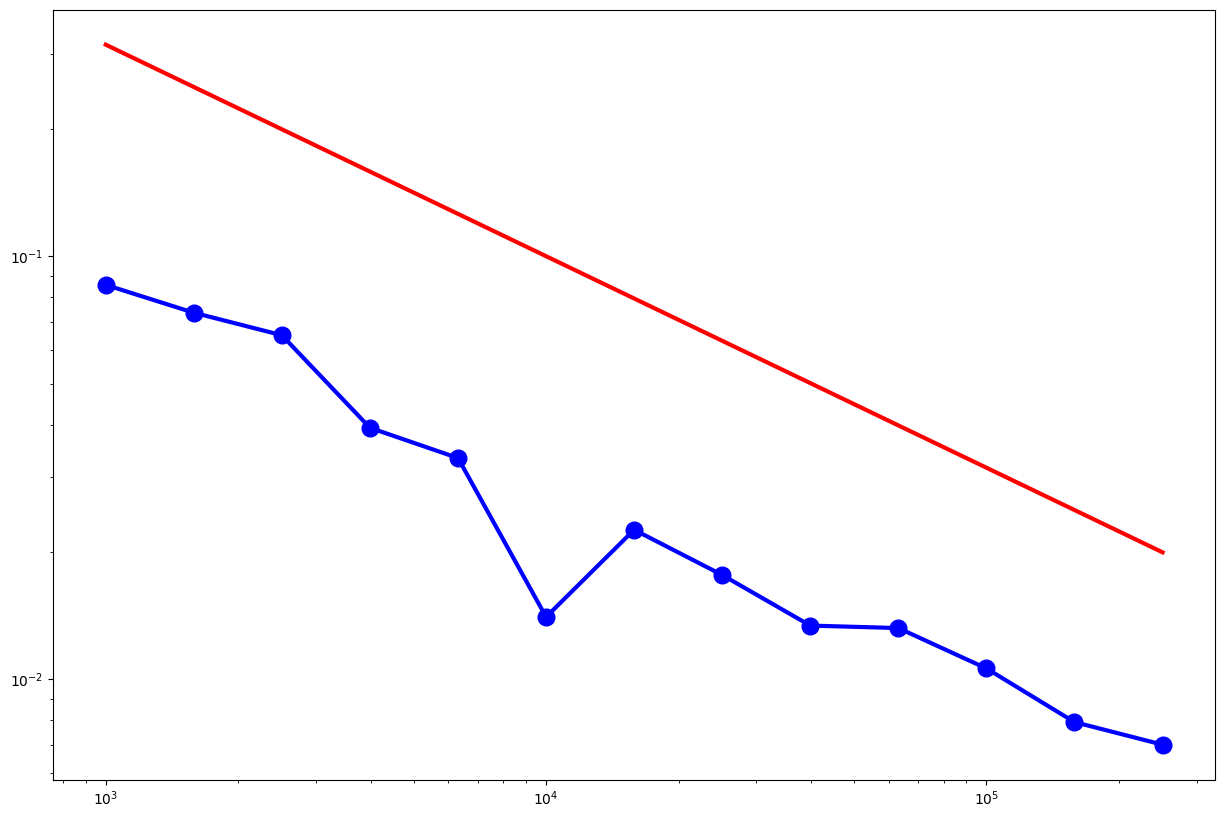

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

eigenvalue_linewidth = 3
eigenvalue_markersize = 12

ax.loglog(drum_nums_Vs, eigs_difs, 'o-', c='b', linewidth=eigenvalue_linewidth, markersize=eigenvalue_markersize)
ax.loglog(drum_nums_Vs, drum_nums_Vs**(-0.5) * 10, '-', c='r', linewidth=eigenvalue_linewidth, markersize=eigenvalue_markersize)

# ax.hlines(1, 500, 1_000_000)
# ax.set_xlim(800, 400_000)